In [948]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from pymongo import MongoClient
from sklearn.impute import SimpleImputer

from sklearn.metrics import (f1_score, confusion_matrix, classification_report,
                              roc_curve, auc, precision_recall_curve)
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              HistGradientBoostingClassifier)
from sklearn.linear_model import (LogisticRegression, RidgeClassifier, Lasso)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier




In [974]:
client = MongoClient('mongodb://localhost:27017/')
db = client['tcc-data-analysis']

# Importação de todas as coleções salvas no banco de dados
commits = db['commits'].find()
prs = db['react_prs'].find()
bugs = db['react_bugs'].find()
diffs = db['commit_diffs'].find()
commits_prs = db['commits_prs'].find()
commit_files = db['commit_file_history'].find()

In [950]:
pd_commits = pd.DataFrame((commits))
pd_prs = pd.DataFrame((prs))
pd_issues = pd.DataFrame((bugs))
pd_diffs = pd.DataFrame((diffs))
pd_commits_prs = pd.DataFrame((commits_prs))
pd_commit_file_history = pd.DataFrame((commit_files))

In [951]:
commit_diff = pd.merge(pd_commits,
                       pd_diffs, left_on='sha', right_on='commit', 
                       how='left')

pd_commits_prs =  pd.merge(
    pd_commits_prs[['commit_hash','pull_number']], 
    pd_issues[['number', 'title', 'user', 'created_at', 'updated_at', 'closed_at', 'body']], 
    left_on='pull_number', 
    right_on='number', 
    how='left')


merged = pd.merge(
    commit_diff, 
    pd_commits_prs[['commit_hash', 'pull_number', 'number', 'title', 'user', 'created_at',
       'updated_at', 'closed_at', 'body']], 
    left_on='sha', 
    right_on='commit_hash', 
    how='left')

In [952]:
merged['num_files_changed'] = pd_commit_file_history['data'].apply(lambda x: len(x))
merged['previous_commits'] = pd_commit_file_history['data'].apply(lambda x: [d['previous_commit'] for d in x])

In [953]:
def calculate_lines(diff):
    if diff is None:
        return pd.Series([0, 0])
    
    lines_added = diff.count('\n+') - diff.count('+++')
    lines_removed = diff.count('\n-') - diff.count('---')
    
    return pd.Series([lines_added, lines_removed])

merged[['lines_added', 'lines_removed']] = merged['diff'].apply(calculate_lines)



In [954]:
merged['commit_size'] = merged['lines_added'] + merged['lines_removed']

In [955]:
merged['files'] = merged['files'].apply(lambda x: x if isinstance(x, list) else [])
merged['files_modified'] = merged['files'].apply(len)

In [956]:
bug_keywords = ["bug", "regression", "resolution","fix", "duplicate", "invalid", 
                "needs more information", "stale", "wontfix"]

In [957]:
def check_for_labels(row):
    body = str(row['body']) if pd.notna(row['body']) else ''
    title = str(row['title']) if pd.notna(row['title']) else ''
    body_present = any(label in body.lower() for label in bug_keywords)
    title_present = any(label in title.lower() for label in bug_keywords)
    return body_present or title_present

merged['pr_bug_keyword'] = merged.apply(check_for_labels, axis=1)

merged = merged.loc[:, ~merged.columns.duplicated()]



In [958]:
def categorize_commit_type(message):
    if pd.notna(message):
        if 'fix' in message.lower():
            return 'Bug Fix'
        elif 'feature' in message.lower():
            return 'Feature'
        elif 'refactor' in message.lower():
            return 'Refactor'
        else:
            return 'Other'
    return 'Unknown'

merged['commit_type'] = merged['body'].apply(categorize_commit_type)

In [959]:
def categorize_time_between_commits(created, updated, closed):
    
    created = pd.to_datetime(created, errors='coerce')
    updated = pd.to_datetime(updated, errors='coerce')
    closed = pd.to_datetime(closed, errors='coerce')
    if pd.notna(created):
        created = created.tz_localize(None)
    if pd.notna(updated):
        updated = updated.tz_localize(None)
    if pd.notna(closed):
        closed = closed.tz_localize(None)

    latest_event = created
    if pd.notna(updated) and (latest_event is pd.NaT or (updated > latest_event)):
        latest_event = updated
    if pd.notna(closed) and (latest_event is pd.NaT or (closed > latest_event)):
        latest_event = closed

    if latest_event is pd.NaT:
        return 'Unknown'
    
    time_delta = pd.Timestamp.now() - latest_event
    days = time_delta.days

    if days < 1:
        return 'Less than a day'
    elif days < 7:
        return 'Less than a week'
    elif days < 30:
        return 'Less than a month'
    elif days < 60:
        return 'Less than two months'
    elif days < 90:
        return 'Less than three months'
    else:
        return 'More than three months'

merged['time_since_last_commit'] = merged.apply(
    lambda row: categorize_time_between_commits(row['created_at'], row['updated_at'], row['closed_at']),
    axis=1
)

In [960]:

def categorize_file_modifications(num_files):
    if num_files == 0:
        return 'None'
    elif num_files <= 5:
        return 'Few'
    elif num_files <= 20:
        return 'Moderate'
    else:
        return 'Many'

merged['file_modifications_category'] = merged['num_files_changed'].apply(categorize_file_modifications)

In [961]:


def categorize_lines_changed(lines_added, lines_removed):
    if lines_added > 1000 or lines_removed > 100:
        return 'Major'
    elif lines_added > 100 or lines_removed > 100:
        return 'Significant'
    else:
        return 'Minor'

merged['lines_change_category'] = merged.apply(lambda row: categorize_lines_changed(row['lines_added'], row['lines_removed']), axis=1)

In [962]:
def extract_author_id(author):
    if isinstance(author, dict) and 'id' in author:
        return author['id']
    return None

merged['author_id'] = merged['author'].apply(extract_author_id)
merged['commit_frequency'] = merged.groupby('author_id')['commit_hash'].transform('count')

In [963]:
features = ['sha','parents', 'stats', 'files', 'title','created_at', 'updated_at', 'closed_at', 
             'num_files_changed', 'previous_commits', 'lines_added', 'lines_removed', 'commit_size', 
             'files_modified', 'pr_bug_keyword', 'author_id', 'commit_frequency']

categories = ['commit_type', 'time_since_last_commit', 'file_modifications_category',
       'lines_change_category']

target= ['bug_count']

fields = features + target + categories

In [964]:
bug_count = merged['bug_count']
mean_bug_count = bug_count.mean()
median_bug_count = bug_count.median()
std_bug_count = bug_count.std()

print(f"Média de bug_count: {mean_bug_count:.2f}")
print(f"Mediana de bug_count: {median_bug_count:.2f}")
print(f"Desvio padrão de bug_count: {std_bug_count:.2f}")


Média de bug_count: 2.66
Mediana de bug_count: 0.00
Desvio padrão de bug_count: 18.06


In [965]:

X = merged[features + categories]
y = (merged[target] < 1) 

numeric_features = ['num_files_changed', 'lines_added', 'lines_removed', 'commit_size', 'files_modified', 'commit_frequency', 'pr_bug_keyword']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categories)
    ]
)

X_processed = pd.DataFrame(preprocessor.fit_transform(X), index=X.index)

z_scores = np.abs(stats.zscore(X_processed, axis=0))
threshold = 3
mask = (z_scores < threshold).all(axis=1)

X_filtered = X_processed[mask]
y_filtered = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)

models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'RidgeClassifier': RidgeClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(),
    'HistGradientBoosting': HistGradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

results = {}
ac = []
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[name] = scores.mean()
    ac = ac + [scores.mean()]

for name, accuracy in results.items():
    print(f"{name}: Accuracy = {accuracy:.2f}")

C:\Users\Rafael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Rafael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Rafael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

RandomForest: Accuracy = 0.96
LogisticRegression: Accuracy = 0.96
RidgeClassifier: Accuracy = 0.96
DecisionTree: Accuracy = 0.94
GradientBoosting: Accuracy = 0.96
KNN: Accuracy = 0.96
SVC: Accuracy = 0.96
HistGradientBoosting: Accuracy = 0.95
XGBoost: Accuracy = 0.95


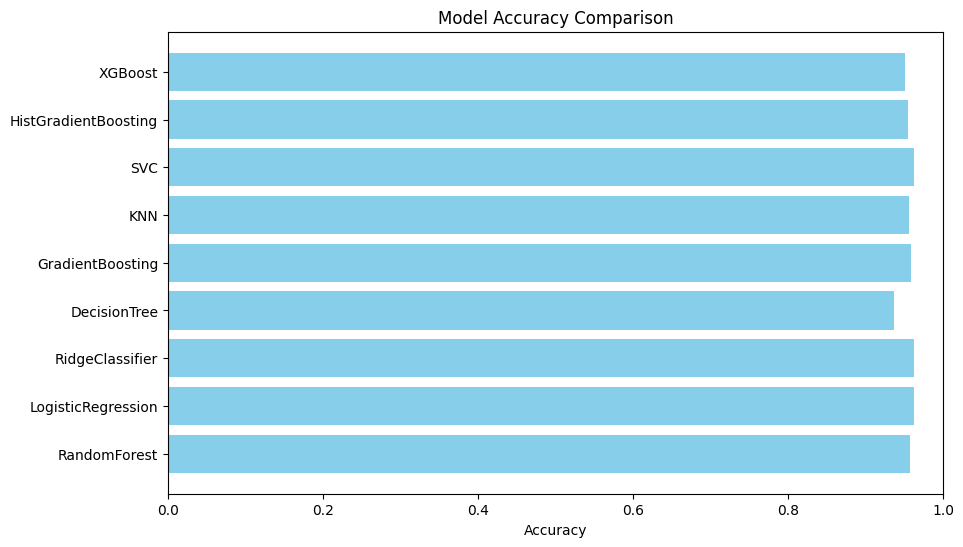

In [966]:
models = ['RandomForest', 'LogisticRegression', 'RidgeClassifier', 'DecisionTree', 
          'GradientBoosting', 'KNN', 'SVC', 'HistGradientBoosting', 'XGBoost']

plt.figure(figsize=(10, 6))
plt.barh(models, ac, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 1)
plt.show()


In [967]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

C:\Users\Rafael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [968]:
report = classification_report(y_test, y_pred, target_names=['Menor que 1', 'Maior que 1'])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

 Menor que 1       0.88      1.00      0.93       281
 Maior que 1       1.00      0.95      0.97       802

    accuracy                           0.96      1083
   macro avg       0.94      0.98      0.95      1083
weighted avg       0.97      0.96      0.96      1083



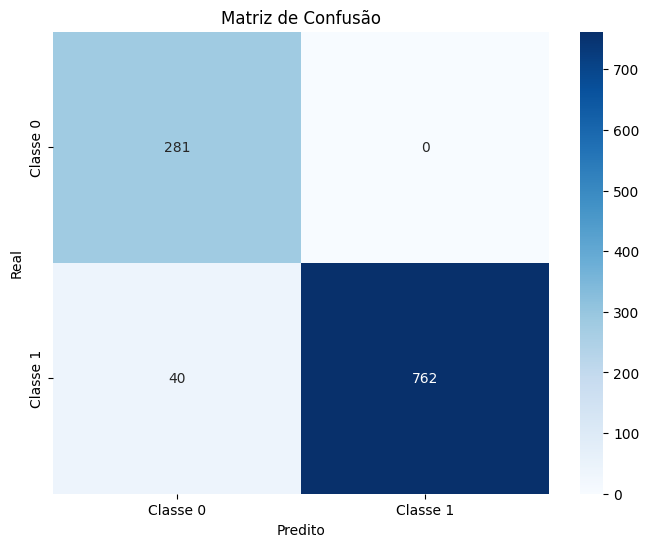

In [969]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

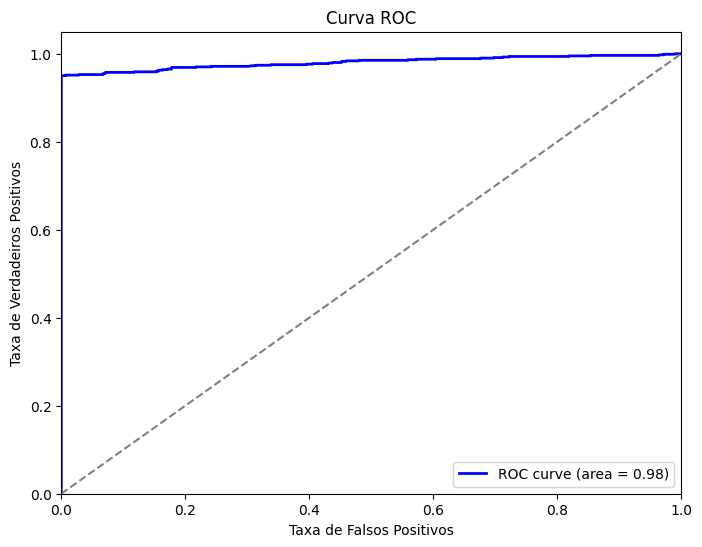

In [970]:
y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

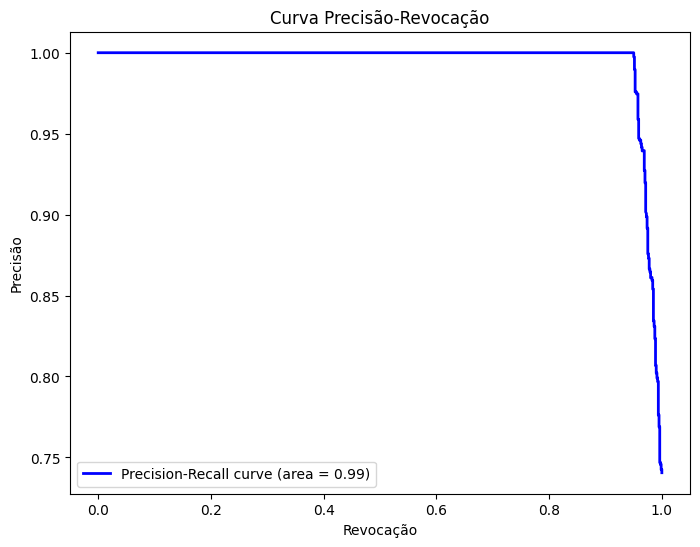

In [971]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Revocação')
plt.ylabel('Precisão')
plt.title('Curva Precisão-Revocação')
plt.legend(loc="lower left")
plt.show()

In [972]:
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.2f}")

F1-Score: 0.97


C:\Users\Rafael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Rafael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Rafael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

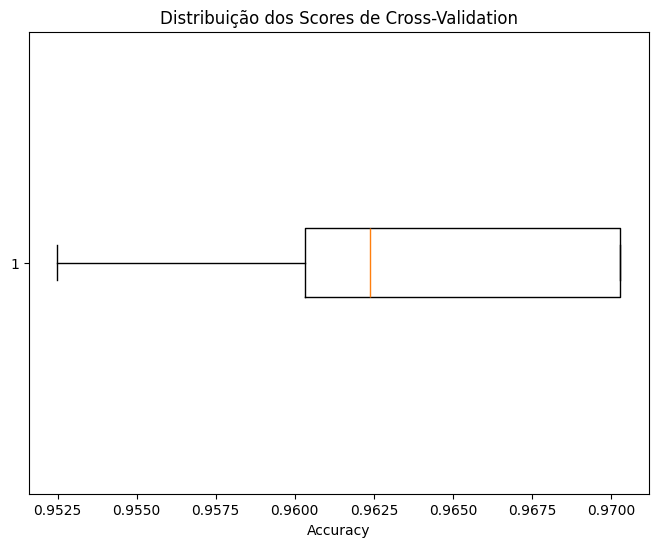

In [973]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

plt.figure(figsize=(8, 6))
plt.boxplot(cv_scores, vert=False)
plt.xlabel('Accuracy')
plt.title('Distribuição dos Scores de Cross-Validation')
plt.show()